In [2]:
import sys
sys.path.append(r'/zhome/60/1/118435/Master_Thesis/GoalCornerDetection')
sys.path.append(r'/zhome/60/1/118435/Master_Thesis/GoalCornerDetection/Core/torchhelpers')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
import torch
import numpy as np
import matplotlib.pyplot as plt
from Core.helpers import to_torch,to_numpy,split_data_train_test
from Core.DataLoader import GoalCalibrationDataset
from Core.plottools import target_to_keypoints,batch_target_to_keypoints,plot_batch_keypoints,visualize
from utils import DATA_DIR
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import pickle

In [3]:
GoalData = GoalCalibrationDataset(DATA_DIR)

All images: 854
All annotations: 854
Filtered images: 754
Filtered annotations: 754


In [4]:
# image_ids = []
# widths = []
# heights = []

# for _, target in tqdm(GoalData):
#     image_ids.append(target['image_id'].numpy()[0])
#     tbox = target['boxes'][0].numpy()
#     widths.append(tbox[2]-tbox[0])
#     heights.append(tbox[3]-tbox[1])

In [5]:
with open('/zhome/60/1/118435/Master_Thesis/GoalCornerDetection/Tests/data_for_anchorboxes/widths.list', 'rb') as f:
    widths = pickle.load(f)
with open('/zhome/60/1/118435/Master_Thesis/GoalCornerDetection/Tests/data_for_anchorboxes/heights.list', 'rb') as f:
    heights = pickle.load(f)


best fit line:
y = 735.90 + 1.92x


Text(0.5, 0, 'width')

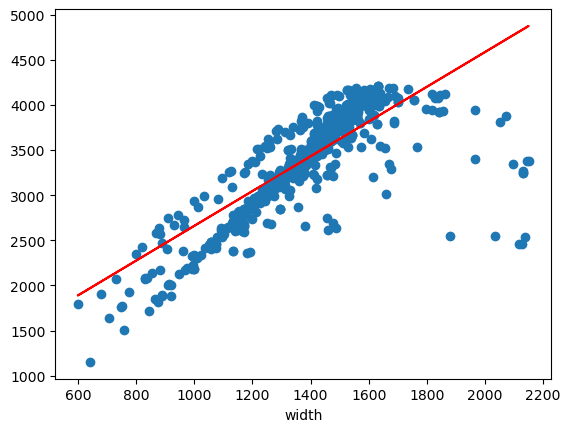

In [6]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

# solution
X = heights
Y = widths
a, b = best_fit(X, Y)
#best fit line:
#y = 735.90 + 1.92x

# plot points and fit line
import matplotlib.pyplot as plt
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit, 'r')
plt.xlabel(f'height')
plt.xlabel(f'width')


In [31]:
data = np.stack((widths,heights),axis=1)
data.shape

(754, 2)

Aspect Ratios: [2.4491165 2.3399239 2.4998176 2.2922435 2.5277627]
Scales: [8.323299  5.1938314 9.2189865 7.0469594 9.924963 ]


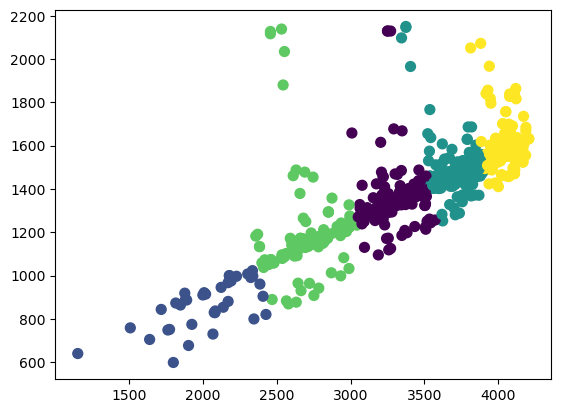

In [35]:
K = KMeans(5,)
clustering = K.fit(data)
plt.scatter(data[:, 0], data[:, 1], c=clustering.labels_, s=50, cmap='viridis')


out = clustering.cluster_centers_

ar = out[:,0] / out[:,1]
scale = out[:,1] * np.sqrt(ar) / 256

print("Aspect Ratios: {}".format(ar))

print("Scales: {}".format(scale))
